# Домашнее задание № 8

In [25]:
!pip install pandas scikit-learn matplotlib
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
from sklearn.metrics import classification_report

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
data = pd.read_csv('/content/drive/MyDrive/КомпЛинг/lenta_40k.csv')

In [29]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [30]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [31]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [32]:
len(vocab)

354611

In [33]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [34]:
len(filtered_vocab)

24091

In [35]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [36]:
id2word = {i:word for word, i in word2id.items()}

In [37]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [38]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

## **1. Модель с 1 GRU слоем**

In [40]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model1.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 13s 251ms/step - loss: 2.5515 - f1: 8.5981e-04 - rec@prec: 0.0000e+00 - val_loss: 2.3261 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/20
43/43 [==============================] - 7s 165ms/step - loss: 2.2732 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2083 - val_f1: 6.6600e-04 - val_rec@prec: 0.0041
Epoch 3/20
43/43 [==============================] - 7s 157ms/step - loss: 2.0843 - f1: 0.0355 - rec@prec: 0.0025 - val_loss: 2.1112 - val_f1: 0.0160 - val_rec@prec: 0.0063
Epoch 4/20
43/43 [==============================] - 4s 102ms/step - loss: 1.8890 - f1: 0.1012 - rec@prec: 0.0191 - val_loss: 1.9081 - val_f1: 0.0913 - val_rec@prec: 0.0352
Epoch 5/20
43/43 [==============================] - 5s 119ms/step - loss: 1.6699 - f1: 0.2198 - rec@prec: 0.0972 - val_loss: 1.8439 - val_f1: 0.2581 - val_rec@prec: 0.0509
Epoch 6/20
43/43 [==============================] - 4s 100ms/step - loss: 1.4506 - f1: 0.3722 - rec@prec: 0.225

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


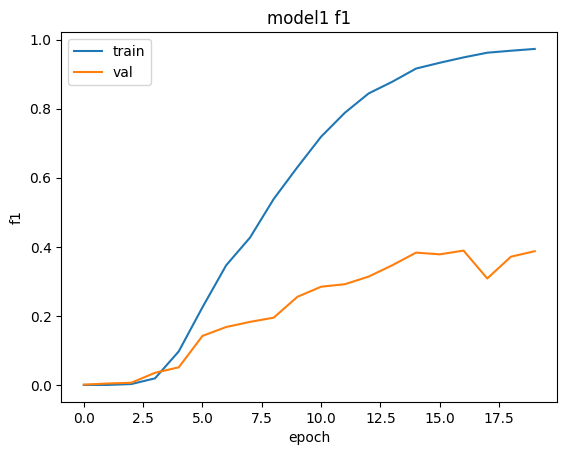

In [ ]:
print(model1.history.history.keys())
# summarize history for accuracy
plt.plot(model1.history.history['rec@prec'])
plt.plot(model1.history.history['val_rec@prec'])
plt.title('model1 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model1.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))


              precision    recall  f1-score   support

           0       0.77      0.48      0.59        21
           1       0.88      0.97      0.92       481
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.70      0.47      0.56        60
           5       0.90      0.85      0.88       132
           6       0.95      0.95      0.95       410
           7       0.94      0.96      0.95       160
           8       0.00      0.00      0.00         4
           9       0.94      0.91      0.93       239
          10       0.85      0.92      0.88        66
          11       0.80      0.18      0.30        22
          12       0.93      0.97      0.95       159
          13       0.92      0.96      0.94        23
          14       0.90      0.88      0.89        84
          15       0.85      0.90      0.87       159
          17       0.99      0.99      0.99       195

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **2. Модель с 1 LSTM слоем**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model2.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 11s 176ms/step - loss: 2.4828 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3192 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 7s 156ms/step - loss: 2.3122 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.2971 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 3/20
43/43 [==============================] - 5s 112ms/step - loss: 2.2527 - f1: 4.1561e-04 - rec@prec: 0.0032 - val_loss: 2.1801 - val_f1: 0.0000e+00 - val_rec@prec: 0.0167
Epoch 4/20
43/43 [==============================] - 4s 101ms/step - loss: 1.8675 - f1: 0.1020 - rec@prec: 0.0491 - val_loss: 1.6971 - val_f1: 0.3518 - val_rec@prec: 0.0753
Epoch 5/20
43/43 [==============================] - 5s 123ms/step - loss: 1.5681 - f1: 0.4046 - rec@prec: 0.1653 - val_loss: 1.5932 - val_f1: 0.3614 - val_rec@prec: 0.1443
Epoch 6/20
43/43 [==============================] - 4s 92ms/step - loss: 1.5098 - f1: 0.4302 - rec@prec

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


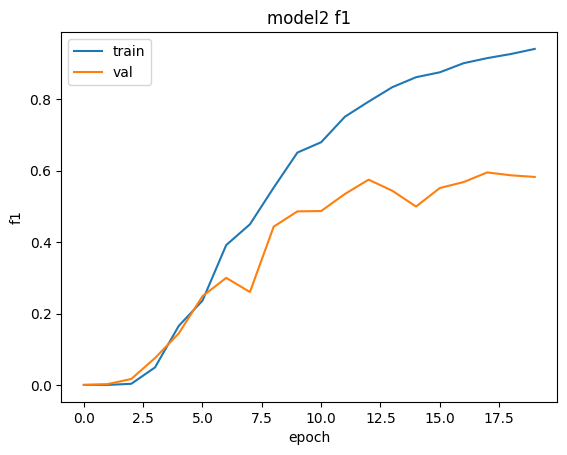

In [ ]:
print(model2.history.history.keys())
# summarize history for accuracy
plt.plot(model2.history.history['rec@prec'])
plt.plot(model2.history.history['val_rec@prec'])
plt.title('model2 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model2.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))


              precision    recall  f1-score   support

           0       0.12      0.05      0.07        21
           1       0.66      0.78      0.71       481
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.17      0.05      0.08        60
           5       0.52      0.49      0.51       132
           6       0.75      0.70      0.72       410
           7       0.79      0.76      0.77       160
           8       0.00      0.00      0.00         4
           9       0.78      0.78      0.78       239
          10       0.67      0.67      0.67        66
          11       0.08      0.05      0.06        22
          12       0.73      0.72      0.73       159
          13       0.43      0.26      0.32        23
          14       0.21      0.33      0.26        84
          15       0.64      0.61      0.63       159
          17       0.98      0.94      0.96       195

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **3. Модель с 1 GRU и 1 LSTM слоем**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model3.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 33s 125ms/step - loss: 2.1125 - f1: 0.0215 - rec@prec: 4.7463e-05 - val_loss: 1.6966 - val_f1: 0.0982 - val_rec@prec: 0.0334
Epoch 2/15
211/211 [==============================] - 18s 84ms/step - loss: 1.2988 - f1: 0.4484 - rec@prec: 0.2953 - val_loss: 1.1639 - val_f1: 0.6275 - val_rec@prec: 0.4838
Epoch 3/15
211/211 [==============================] - 14s 66ms/step - loss: 0.8795 - f1: 0.7282 - rec@prec: 0.6831 - val_loss: 0.9983 - val_f1: 0.6952 - val_rec@prec: 0.6253
Epoch 4/15
211/211 [==============================] - 13s 60ms/step - loss: 0.6497 - f1: 0.8091 - rec@prec: 0.8196 - val_loss: 1.0352 - val_f1: 0.7124 - val_rec@prec: 0.6326
Epoch 5/15
211/211 [==============================] - 11s 52ms/step - loss: 0.5141 - f1: 0.8509 - rec@prec: 0.8794 - val_loss: 1.1386 - val_f1: 0.7091 - val_rec@prec: 0.5987
Epoch 6/15
211/211 [==============================] - 10s 50ms/step - loss: 0.4024 - f1: 0.8835 - rec@prec: 0.9218 - val_loss

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


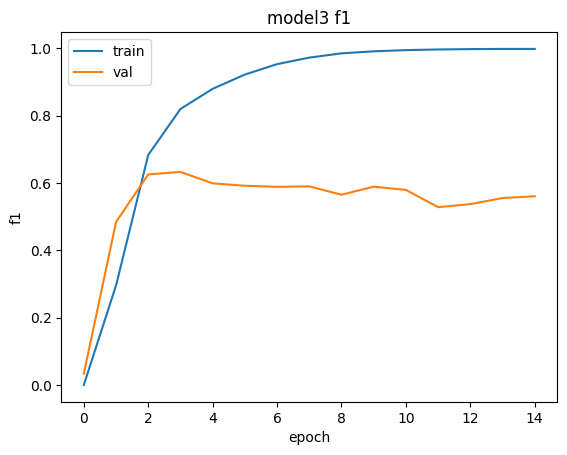

In [ ]:
print(model3.history.history.keys())
# summarize history for accuracy
plt.plot(model3.history.history['rec@prec'])
plt.plot(model3.history.history['val_rec@prec'])
plt.title('model3 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model3.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))

              precision    recall  f1-score   support

           0       0.14      0.14      0.14        21
           1       0.69      0.73      0.71       481
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.48      0.23      0.31        60
           5       0.56      0.50      0.53       132
           6       0.71      0.71      0.71       410
           7       0.70      0.68      0.69       160
           8       0.00      0.00      0.00         4
           9       0.73      0.80      0.77       239
          10       0.73      0.70      0.71        66
          11       0.25      0.18      0.21        22
          12       0.71      0.76      0.73       159
          13       0.71      0.43      0.54        23
          14       0.26      0.30      0.28        84
          15       0.67      0.67      0.67       159
          17       0.95      0.91      0.93       195

    accuracy              

## **4. Модель с 1 BIGRU и 2 LSTM слоями**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model4 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model4.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 44s 156ms/step - loss: 2.3068 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 1.9421 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
211/211 [==============================] - 25s 118ms/step - loss: 1.7785 - f1: 0.0922 - rec@prec: 0.0330 - val_loss: 1.6770 - val_f1: 0.1873 - val_rec@prec: 0.1023
Epoch 3/15
211/211 [==============================] - 22s 106ms/step - loss: 1.5678 - f1: 0.2367 - rec@prec: 0.1245 - val_loss: 1.5802 - val_f1: 0.2666 - val_rec@prec: 0.1285
Epoch 4/15
211/211 [==============================] - 21s 100ms/step - loss: 1.4054 - f1: 0.3443 - rec@prec: 0.1843 - val_loss: 1.4509 - val_f1: 0.3311 - val_rec@prec: 0.2024
Epoch 5/15
211/211 [==============================] - 20s 96ms/step - loss: 1.2497 - f1: 0.4733 - rec@prec: 0.2914 - val_loss: 1.3890 - val_f1: 0.4659 - val_rec@prec: 0.2782
Epoch 6/15
211/211 [==============================] - 20s 95ms/step - loss: 1.0879 - f1: 0.5924 - rec@prec: 0.

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


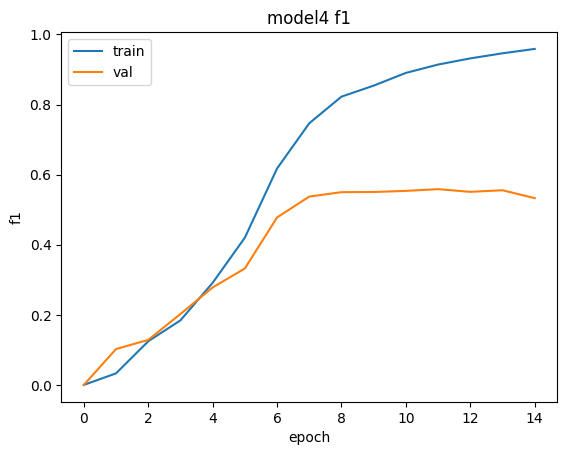

In [ ]:
print(model4.history.history.keys())
# summarize history for accuracy
plt.plot(model4.history.history['rec@prec'])
plt.plot(model4.history.history['val_rec@prec'])
plt.title('model4 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model4.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))

              precision    recall  f1-score   support

           0       0.07      0.19      0.11        21
           1       0.70      0.68      0.69       481
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.17      0.18      0.18        60
           5       0.36      0.45      0.40       132
           6       0.77      0.62      0.69       410
           7       0.70      0.76      0.73       160
           8       0.00      0.00      0.00         4
           9       0.80      0.73      0.76       239
          10       0.66      0.73      0.69        66
          11       0.20      0.23      0.21        22
          12       0.71      0.67      0.69       159
          13       0.31      0.65      0.42        23
          14       0.30      0.30      0.30        84
          15       0.73      0.75      0.74       159
          17       0.92      0.95      0.93       195

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **5. Модель с 5 GRU слоями и 3 LSTM слоями**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)


dense = tf.keras.layers.Dense(64, activation='relu')(lstm_3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model5 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model5.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model5.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 62s 226ms/step - loss: 2.3494 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3192 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
211/211 [==============================] - 39s 185ms/step - loss: 2.3243 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3229 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
211/211 [==============================] - 35s 164ms/step - loss: 2.3245 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3193 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/15
211/211 [==============================] - 34s 163ms/step - loss: 2.3232 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3219 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/15
211/211 [==============================] - 34s 162ms/step - loss: 2.3230 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3193 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/15
211/211 [=========================

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


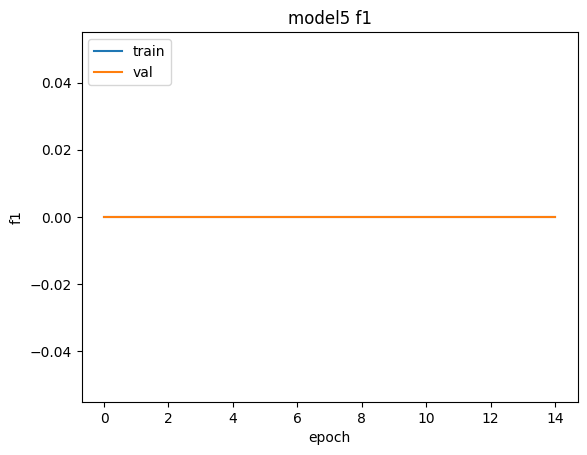

In [ ]:
print(model5.history.history.keys())
# summarize history for accuracy
plt.plot(model5.history.history['rec@prec'])
plt.plot(model5.history.history['val_rec@prec'])
plt.title('model5 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model5.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.22      1.00      0.36       481
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00       132
           6       0.00      0.00      0.00       410
           7       0.00      0.00      0.00       160
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00       239
          10       0.00      0.00      0.00        66
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00       159
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        84
          15       0.00      0.00      0.00       159
          17       0.00      0.00      0.00       195

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6. **Модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

lstm_forward =  tf.keras.layers.GRU(128, return_sequences=False)(embeddings)
lstm_backward =  tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)(embeddings)

hidden = tf.keras.layers.concatenate([lstm_forward, lstm_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model6.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 40s 120ms/step - loss: 2.2059 - f1: 0.0029 - rec@prec: 0.0000e+00 - val_loss: 1.9484 - val_f1: 0.0000e+00 - val_rec@prec: 4.5086e-04
Epoch 2/15
211/211 [==============================] - 19s 90ms/step - loss: 1.7791 - f1: 0.1179 - rec@prec: 0.0125 - val_loss: 1.9936 - val_f1: 0.2594 - val_rec@prec: 0.0491
Epoch 3/15
211/211 [==============================] - 13s 63ms/step - loss: 1.5209 - f1: 0.2472 - rec@prec: 0.1281 - val_loss: 1.4487 - val_f1: 0.3394 - val_rec@prec: 0.1677
Epoch 4/15
211/211 [==============================] - 11s 54ms/step - loss: 1.3015 - f1: 0.4516 - rec@prec: 0.2682 - val_loss: 1.3963 - val_f1: 0.4834 - val_rec@prec: 0.2931
Epoch 5/15
211/211 [==============================] - 11s 51ms/step - loss: 1.0999 - f1: 0.6151 - rec@prec: 0.4780 - val_loss: 1.1830 - val_f1: 0.6479 - val_rec@prec: 0.4851
Epoch 6/15
211/211 [==============================] - 10s 47ms/step - loss: 0.9329 - f1: 0.6975 - rec@prec: 0.6319 - 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


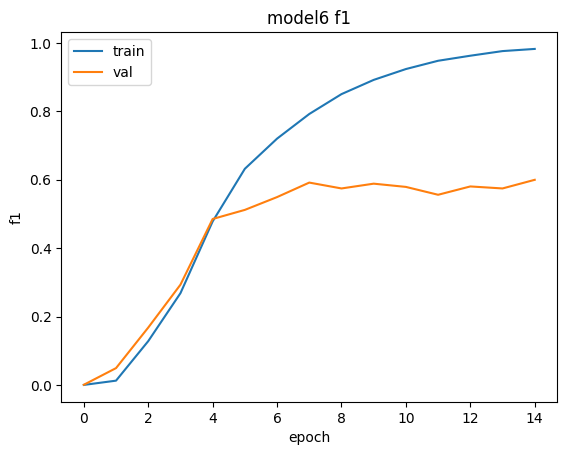

In [ ]:
print(model6.history.history.keys())
# summarize history for accuracy
plt.plot(model6.history.history['rec@prec'])
plt.plot(model6.history.history['val_rec@prec'])
plt.title('model6 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model6.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))

              precision    recall  f1-score   support

           0       0.33      0.31      0.32        84
           1       0.72      0.84      0.78       239
           2       0.00      0.00      0.00         2
           3       0.45      0.23      0.31        60
           4       0.69      0.70      0.70       481
           5       0.74      0.66      0.70       410
           6       0.72      0.82      0.77       160
           7       0.00      0.00      0.00         4
           8       0.77      0.81      0.79       159
          10       0.92      0.93      0.93       195
          11       0.00      0.00      0.00         1
          13       0.63      0.64      0.63        66
          14       0.66      0.74      0.70       159
          15       0.57      0.55      0.56       132
          16       0.61      0.48      0.54        23
          17       0.25      0.32      0.28        22
          18       0.20      0.10      0.13        21

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **7. Модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM**

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru_1)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model7= tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model7.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 89s 320ms/step - loss: 2.3475 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3250 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
211/211 [==============================] - 46s 217ms/step - loss: 2.3286 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3212 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
211/211 [==============================] - 41s 194ms/step - loss: 2.3223 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2176 - val_f1: 0.0000e+00 - val_rec@prec: 0.0491
Epoch 4/15
211/211 [==============================] - 39s 184ms/step - loss: 1.9687 - f1: 0.0285 - rec@prec: 1.1866e-04 - val_loss: 1.9121 - val_f1: 0.1104 - val_rec@prec: 0.0000e+00
Epoch 5/15
211/211 [==============================] - 34s 162ms/step - loss: 1.8139 - f1: 0.0826 - rec@prec: 0.0366 - val_loss: 1.7837 - val_f1: 0.0885 - val_rec@prec: 0.0464
Epoch 6/15
211/211 [==============================] - 35s 166ms/step - lo

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


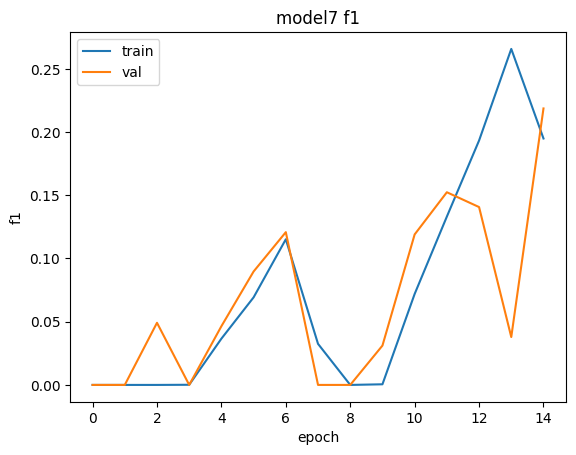

In [ ]:
print(model7.history.history.keys())
# summarize history for accuracy
plt.plot(model7.history.history['rec@prec'])
plt.plot(model7.history.history['val_rec@prec'])
plt.title('model7 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model7.predict(X_valid, batch_size=128, verbose=0)
pred = np.argmax(rounded_predictions, axis=1)

rounded_labels=np.argmax(y_valid, axis=1)
rounded_labels

print(classification_report(rounded_labels, pred))

              precision    recall  f1-score   support

           0       0.12      0.13      0.13        84
           1       0.58      0.76      0.66       239
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00        60
           4       0.61      0.65      0.63       481
           5       0.50      0.64      0.56       410
           6       0.26      0.16      0.20       160
           7       0.00      0.00      0.00         4
           8       0.33      0.52      0.40       159
          10       0.96      0.92      0.94       195
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00        66
          14       0.71      0.63      0.67       159
          15       0.13      0.09      0.11       132
          16       0.00      0.00      0.00        23
          17       0.00      0.00      0.00        22
          18       0.00      0.00      0.00        21

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Победитель - модель № 1 (модель с 1 GRU слоем)

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [5]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset

In [7]:
dataset = load_dataset("wikiann", 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [83]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [84]:
len(vocab)

36015

In [85]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [86]:
id2word = {i:word for word, i in word2id.items()}

In [87]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [88]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [89]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [90]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [91]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [74]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [75]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

In [20]:
import gensim.downloader

In [92]:
glove_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

In [93]:
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0], output_dim=300, weights=[glove_vectors.vectors], input_length=MAX_LEN, trainable=False) (inputs)

BISTLM1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
BISTLM2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(BISTLM1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BISTLM2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [117]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=15)

Epoch 1/15
157/157 [==============================] - 4s 26ms/step - loss: 0.0470 - accuracy: 0.9841 - val_loss: 0.0964 - val_accuracy: 0.9721
Epoch 2/15
157/157 [==============================] - 5s 31ms/step - loss: 0.0448 - accuracy: 0.9849 - val_loss: 0.0886 - val_accuracy: 0.9745
Epoch 3/15
157/157 [==============================] - 5s 29ms/step - loss: 0.0425 - accuracy: 0.9856 - val_loss: 0.0947 - val_accuracy: 0.9729
Epoch 4/15
157/157 [==============================] - 4s 25ms/step - loss: 0.0413 - accuracy: 0.9860 - val_loss: 0.1037 - val_accuracy: 0.9709
Epoch 5/15
157/157 [==============================] - 5s 29ms/step - loss: 0.0388 - accuracy: 0.9869 - val_loss: 0.0962 - val_accuracy: 0.9724
Epoch 6/15
157/157 [==============================] - 4s 25ms/step - loss: 0.0375 - accuracy: 0.9873 - val_loss: 0.0968 - val_accuracy: 0.9729
Epoch 7/15
157/157 [==============================] - 4s 25ms/step - loss: 0.0350 - accuracy: 0.9881 - val_loss: 0.0943 - val_accuracy: 0.9741

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


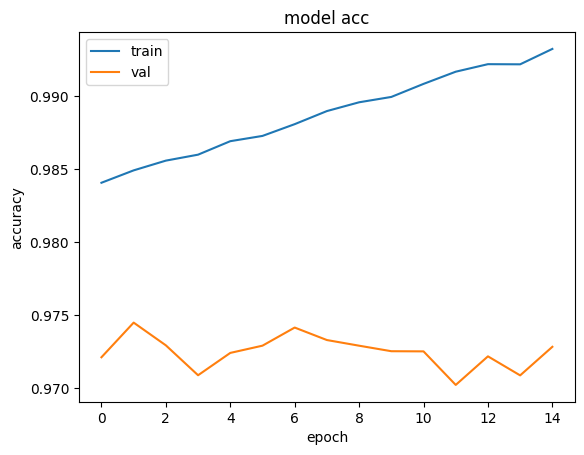

In [118]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [96]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [119]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 23ms/step


[('Алексей', 'B-LOC'),
 ('сказал', 'O'),
 ('Светлане', 'O'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('она', 'O'),
 ('собиралась', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [120]:
label_seq('Леонид работал в компании Шебекино, где производят макароны.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 22ms/step


[('Леонид', 'O'),
 ('работал', 'O'),
 ('в', 'O'),
 ('компании', 'B-LOC'),
 ('Шебекино', 'I-LOC'),
 (',', 'O'),
 ('где', 'B-LOC'),
 ('производят', 'I-LOC'),
 ('макароны', 'I-LOC'),
 ('.', 'O')]

In [110]:
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0], output_dim=300, weights=[glove_vectors.vectors], input_length=MAX_LEN, trainable=False) (inputs)

BIGRU1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
BIGRU2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(BIGRU1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BIGRU2)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [111]:
model_2.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=15)

Epoch 1/15
157/157 [==============================] - 14s 38ms/step - loss: 0.2124 - accuracy: 0.9369 - val_loss: 0.1297 - val_accuracy: 0.9574
Epoch 2/15
157/157 [==============================] - 4s 23ms/step - loss: 0.1060 - accuracy: 0.9648 - val_loss: 0.0963 - val_accuracy: 0.9681
Epoch 3/15
157/157 [==============================] - 4s 22ms/step - loss: 0.0877 - accuracy: 0.9707 - val_loss: 0.0874 - val_accuracy: 0.9717
Epoch 4/15
157/157 [==============================] - 4s 22ms/step - loss: 0.0796 - accuracy: 0.9736 - val_loss: 0.0856 - val_accuracy: 0.9729
Epoch 5/15
157/157 [==============================] - 4s 24ms/step - loss: 0.0746 - accuracy: 0.9753 - val_loss: 0.0828 - val_accuracy: 0.9736
Epoch 6/15
157/157 [==============================] - 4s 28ms/step - loss: 0.0709 - accuracy: 0.9766 - val_loss: 0.0881 - val_accuracy: 0.9713
Epoch 7/15
157/157 [==============================] - 5s 34ms/step - loss: 0.0672 - accuracy: 0.9777 - val_loss: 0.0859 - val_accuracy: 0.972

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


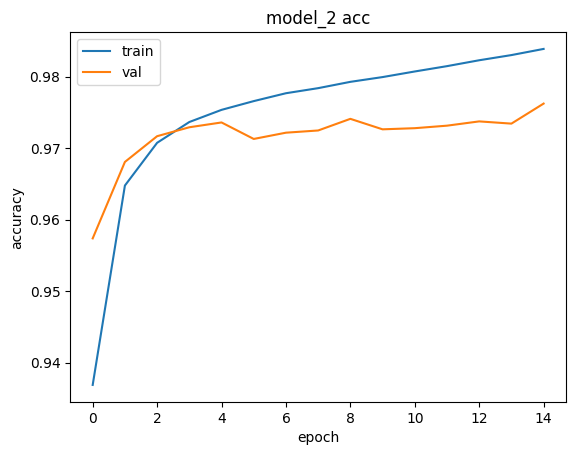

In [112]:
print(model_2.history.history.keys())
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])
plt.title('model_2 acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [115]:
label_seq('Леонид работал в компании Шебекино, где производят макароны.', word2id, id2labels, MAX_LEN, model_2)

1/1 [==============================] - 2s 2s/step


[('Леонид', 'O'),
 ('работал', 'O'),
 ('в', 'O'),
 ('компании', 'B-LOC'),
 ('Шебекино', 'I-LOC'),
 (',', 'O'),
 ('где', 'B-LOC'),
 ('производят', 'O'),
 ('макароны', 'O'),
 ('.', 'O')]

In [121]:
label_seq('Каждое лето она проводила в Ялте, старом лагере на севере края.', word2id, id2labels, MAX_LEN, model_2)

1/1 [==============================] - 0s 94ms/step


[('Каждое', 'O'),
 ('лето', 'O'),
 ('она', 'O'),
 ('проводила', 'O'),
 ('в', 'O'),
 ('Ялте', 'O'),
 (',', 'O'),
 ('старом', 'O'),
 ('лагере', 'O'),
 ('на', 'O'),
 ('севере', 'O'),
 ('края', 'I-ORG'),
 ('.', 'O')]